In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np
import time
from scipy.stats import norm, uniform, bernoulli, gaussian_kde
from scipy.linalg import sqrtm 
from pylab import plot, show, legend
import matplotlib.pyplot as plt
import math 
import scipy
from model_functions import g, simulate_observations
from model_functions import coupled_PMH_cpm, coupled_PMH_proposed
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rcParams['figure.figsize'] = (10.0, 4.0)
int = np.vectorize(int) 

#### Function to calculate IACT:

In [2]:
from scipy import signal as sp  #for FFT

def compute_acf(X):
    """
    use FFT to compute AutoCorrelation Function
    """
    Y = ( X - np.mean(X) ) / np.std(X)
    acf = sp.fftconvolve(Y,Y[::-1], mode='full') / Y.size
    acf = acf[Y.size:]
    return acf



def gewer_estimate_IAT(np_mcmc_traj, verbose=False):
    """
    use Geyer's method to estimate the Integrated Autocorrelation Time
    """
    acf = np.array( compute_acf(np_mcmc_traj) )
    #for parity issues
    max_lag = 10*np.int(acf.size/10)
    acf = acf[:max_lag]
    # let's do Geyer test
    # "gamma" must be positive and decreasing
    gamma = acf[::2] + acf[1::2]
    N = gamma.size    
    n_stop_positive = 2*np.where(gamma<0)[0][0]
    DD = gamma[1:N] - gamma[:(N-1)]
    n_stop_decreasing = 2 * np.where(DD > 0)[0][0]    
    n_stop = min(n_stop_positive, n_stop_decreasing)
    if verbose:
        print( "Lag_max = {}".format(n_stop) )
    IAT = 1 + 2 * np.sum(acf[1:n_stop])
    return IAT

In [3]:
dt    = 10**-3 / 5
delta = 10*dt
T     = 1000
n     = 3

sigma, rho, beta, noise_intensity = 10, 28, 8/3, 0.1
theta = [sigma, rho, beta, noise_intensity]

#setup measurement process

space_between_observations = 1

observation_points = space_between_observations*(np.arange(0, int(n/space_between_observations)) + 1) - 1
m = len(observation_points)
H = np.zeros(( m, n ))
for i in range(m):
    H[ i, observation_points[i] ] = 1

sigma_error = 0.3    
R           = sigma_error*np.diag(np.ones(m))

#generate latent process + observation
y = np.loadtxt('y.out'); x_0 = np.loadtxt('x_0.out'); latent = np.loadtxt('latent.out')

### Run MCMC for $T = 1000$:

In [11]:
sigma_theta = [0, 0.01, 0, 0]
def prior(theta) :
    return 1
rho_CPM = 0.996

In [13]:
n_MCMC = 10000
start_time = time.clock()
theta_OT, accept_OT = coupled_PMH_proposed(100, theta, y, x_0, prior, n_MCMC, sigma_theta, dt, delta, 
                                           g, H, R, 'OT', clambda=100, n_Sinkhorn=150, uv_threshold=10**30) 
time_OT = time.clock()-start_time
print(round(time_OT/60,2), 'minutes for OT')

1083.8 minutes for OT


In [14]:
n_MCMC = 10000

start_time = time.clock()
theta_CPM, accept_CPM = coupled_PMH_cpm(1000, theta, y, x_0, prior, n_MCMC, sigma_theta, 
                                        rho_CPM, dt, delta, g, H, R, 'independent')  
time_CPM = time.clock()-start_time
print(round(time_CPM/60,2), 'minutes for CPM')

5996.84 minutes for CPM


In [18]:
( (round(gewer_estimate_IAT(theta_CPM[1,discard:]),1)*time_CPM) / 
 (round(gewer_estimate_IAT(theta_OT[1,discard:]),1)*time_OT) )

9.2426595043565207

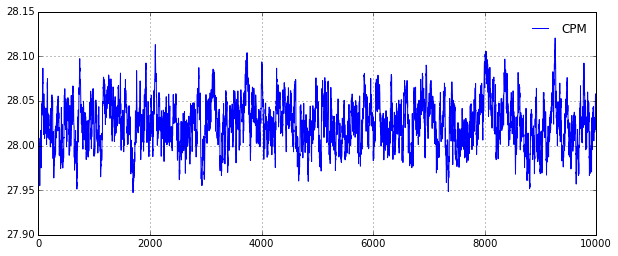

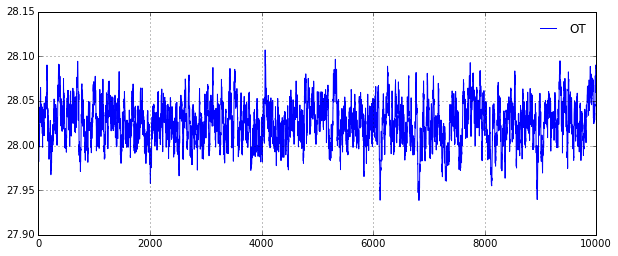

In [15]:
plt.rcParams['figure.figsize'] = (10.0, 4.0)

plt.plot(theta_CPM[1,:], label='CPM')
plt.grid(True)
plt.legend(frameon=False)
plt.show()

plt.plot(theta_OT[1,:], label='OT')
plt.grid(True)
plt.legend(frameon=False)
plt.show()

In [16]:
accept_CPM, accept_OT

(0.7254, 0.7789)

In [17]:
discard = 1000

round(gewer_estimate_IAT(theta_CPM[1,discard:]),1), round(gewer_estimate_IAT(theta_OT[1,discard:]),1)

(44.600000000000001, 26.699999999999999)

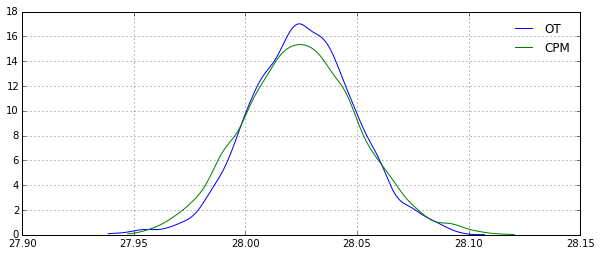

In [19]:
plt.rcParams['figure.figsize'] = (10.0, 4.0)
discard = 500

x_vals = np.linspace(start=np.min(theta_OT[1,discard:]), stop=np.max(theta_OT[1,:]) ,num=200)
plt.plot(x_vals,gaussian_kde(theta_OT[1,:]) (x_vals), label='OT')  

x_vals = np.linspace(start=np.min(theta_CPM[1,discard:]), stop=np.max(theta_CPM[1,:]) ,num=200)
plt.plot(x_vals,gaussian_kde(theta_CPM[1,:]) (x_vals), label='CPM') 

plt.grid(True)
plt.legend(frameon=False)

In [20]:
np.savetxt('theta_CPM_4.out', theta_CPM[1,:])
np.savetxt('theta_OT_4.out' , theta_OT [1,:])

### Run MCMC for $T = 750$:

In [5]:
sigma_theta = [0, 0.015, 0, 0]
def prior(theta) :
    return 1
rho_CPM = 0.996

In [6]:
n_MCMC = 10000

start_time = time.time()
theta_OT, accept_OT = coupled_PMH_proposed(60, theta, y[:,:750], x_0, prior, n_MCMC, sigma_theta, dt, delta, 
                                           g, H, R, 'OT', clambda=100, n_Sinkhorn=150, uv_threshold=10**30) 
time_OT = time.time()-start_time
print(round(time_OT/60,2), 'minutes for OT')

986.73 minutes for OT


In [7]:
start_time = time.time()
theta_CPM, accept_CPM = coupled_PMH_cpm(500, theta, y[:,:750], x_0, prior, n_MCMC, sigma_theta, 
                                        rho_CPM, dt, delta, g, H, R, 'independent')  
time_CPM = time.time() - start_time
print(round(time_CPM/60,2), 'minutes for CPM')

1743.2 minutes for CPM


In [8]:
print( gewer_estimate_IAT(theta_CPM[1,:]), gewer_estimate_IAT(theta_OT[1,:]) )
print( gewer_estimate_IAT(theta_CPM[1,:])*time_CPM / (gewer_estimate_IAT(theta_OT[1,:])*time_OT) )

28.8035066863 18.9422564102
2.68634527818


In [9]:
np.savetxt('theta_CPM_750_4.out', theta_CPM[1,:])
np.savetxt('theta_OT_750_4.out' , theta_OT [1,:])

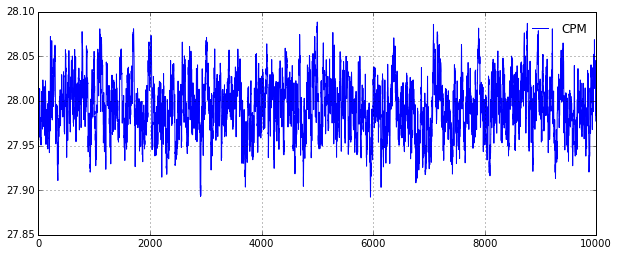

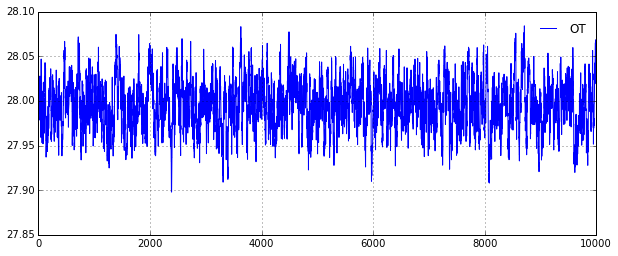

In [10]:
plt.rcParams['figure.figsize'] = (10.0, 4.0)

plt.plot(theta_CPM[1,:], label='CPM')
plt.grid(True)
plt.legend(frameon=False)
plt.show()

plt.plot(theta_OT[1,:], label='OT')
plt.grid(True)
plt.legend(frameon=False)
plt.show()

In [11]:
accept_CPM, accept_OT

(0.7012, 0.7306)

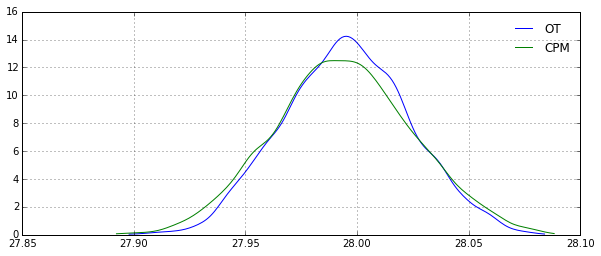

In [12]:
plt.rcParams['figure.figsize'] = (10.0, 4.0)
discard = 1000

x_vals = np.linspace(start=np.min(theta_OT[1,discard:]), stop=np.max(theta_OT[1,:]) ,num=200)
plt.plot(x_vals,gaussian_kde(theta_OT[1,:]) (x_vals), label='OT')  

x_vals = np.linspace(start=np.min(theta_CPM[1,discard:]), stop=np.max(theta_CPM[1,:]) ,num=200)
plt.plot(x_vals,gaussian_kde(theta_CPM[1,:]) (x_vals), label='CPM') 

plt.grid(True)
plt.legend(frameon=False)